# Load all imports

In [3]:
import torch
import torchvision
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt
import helper
import net

# Globals, CNNs, and Device

In [4]:
oriPATH = 'C:/Users/Ryan/Desktop/machine-learning/part2/cnn'

classes = ('0', '1', '2', '3', '4', '5', '6', '7', '8', '9')
learningRates = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1]
numEpochs = 10

sigNet = net.SigNet()
relNet = net.ReluNet()
print(sum([p.numel() for p in sigNet.parameters()]))
print(sum([p.numel() for p in relNet.parameters()]))


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

sigNet = sigNet.to(device)
relNet = relNet.to(device)

884330
884330
cuda:0


# MNIST training and validation set augmentation

In [3]:
valid_ratio = 0.3

transform = transforms.Compose([
    # define your data augmentation here!
    # transforms.RandomRotation(degrees=30),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_valid_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
nb_train = int((1.0 - valid_ratio) * len(train_valid_dataset))
nb_valid =  int(valid_ratio * len(train_valid_dataset))
train_dataset, valid_dataset = torch.utils.data.dataset.random_split(train_valid_dataset, [nb_train, nb_valid])
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=1000, shuffle=True, num_workers=2, pin_memory=True)
validloader = torch.utils.data.DataLoader(valid_dataset, batch_size=1000, shuffle=True, num_workers=2, pin_memory=True)

# Define the loss function and the optimizer.

In [8]:
import torch.nn as nn
import torch.optim as optim

criterion = nn.CrossEntropyLoss()

sigOpt = optim.Adam(sigNet.parameters(), lr=0.001)
relOpt = optim.Adam(relNet.parameters(), lr=0.001)

# Train the CNN and store the best model based on the validation loss.

In [5]:
import time
import os as OO
OO.mkdir(oriPATH + '/task2')
PATH = oriPATH + '/task2'

sigTrainingLoss = []
sigValidationLoss = []
relTrainingLoss = []
relValidationLoss = []

train, val = helper.runCNN(trainloader, device, relOpt, relNet, criterion, validloader, PATH, 'relNet', numEpochs)
relTrainingLoss.append(train)
relValidationLoss.append(val)
train, val = helper.runCNN(trainloader, device, sigOpt, sigNet, criterion, validloader, PATH, 'sigNet', numEpochs)
sigTrainingLoss.append(train)
sigValidationLoss.append(val)

np.save(OO.path.join(PATH, 'sigTrainingLoss.npy'), sigTrainingLoss)
np.save(OO.path.join(PATH, 'sigValidationLoss.npy'), sigValidationLoss)
np.save(OO.path.join(PATH, 'relTrainingLoss.npy'), relTrainingLoss)
np.save(OO.path.join(PATH, 'relValidationLoss.npy'), relValidationLoss)

# Define the test dataset.

In [6]:
transform = transforms.Compose([
     transforms.ToTensor(),
     transforms.Normalize((0.1307,), (0.3081,))
])
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Infer on the whole test dataset.

In [9]:
testloader = torch.utils.data.DataLoader(testset, batch_size=1000, shuffle=False, num_workers=2, pin_memory=True)

import os as OO

sigAccuracy = []
relAccuracy = []

PATH = oriPATH + '/task2'

def printAccuracies(accuracy, testNet, fileName, optimizer):
    newPath = PATH + "/{}_lr_{}".format(fileName, optimizer.defaults['lr'])
    for j in range(numEpochs):
        testNet.load_state_dict(torch.load(OO.path.join(newPath, '{}_epoch_{}.pth'.format(fileName, j))))
        correct, total = helper.testCNN(testloader, testNet, device)
        # print('{} accuracy: %.3F %%'.format(fileName) % (100 * correct / total))
        accuracy.append(100 * correct / total)

testNet = net.SigNet()
testNet = testNet.to(device)
printAccuracies(sigAccuracy,testNet, 'sigNet', sigOpt)
testNet2 = net.ReluNet()
testNet2 = testNet2.to(device)
printAccuracies(relAccuracy,testNet2, 'relNet', relOpt)

sTrain = np.load(OO.path.join(PATH, 'sigTrainingLoss.npy'))
sVal = np.load(OO.path.join(PATH, 'sigValidationLoss.npy'))
rTrain = np.load(OO.path.join(PATH, 'relTrainingLoss.npy'))
rVal = np.load(OO.path.join(PATH, 'relValidationLoss.npy'))

# Graph Training Losses and Accuracy

Text(0, 0.5, 'Training Loss')

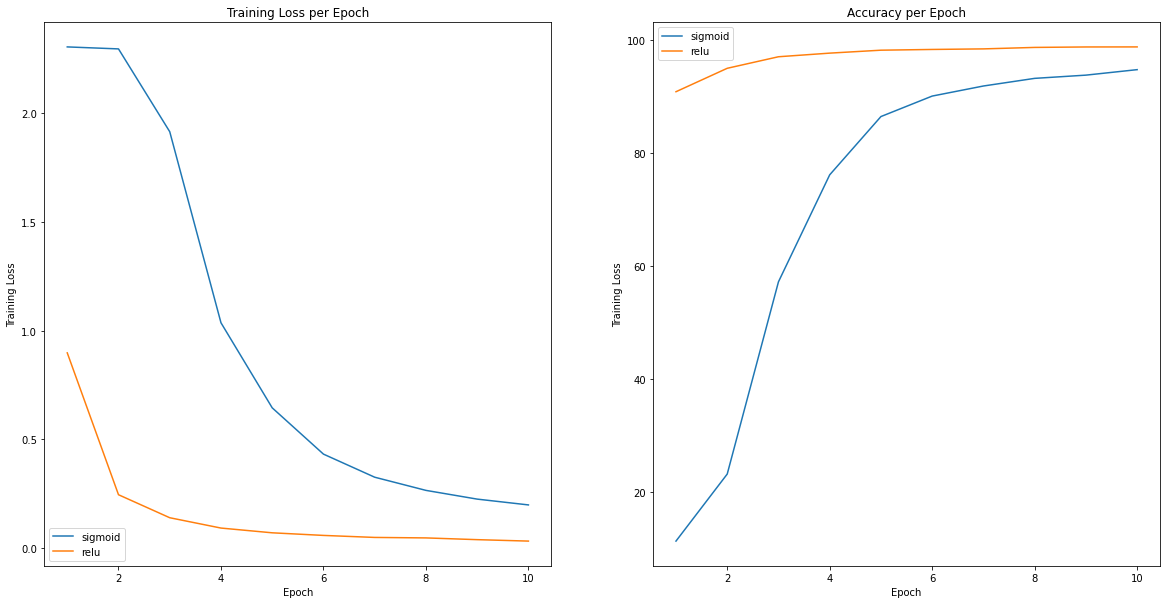

In [10]:
import numpy as np
import matplotlib.pyplot as plt

epochs = range(1, numEpochs + 1)
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(20, 10)

ax[0].plot(epochs, sTrain[0], label='sigmoid')
ax[0].plot(epochs, rTrain[0], label='relu')

ax[1].plot(epochs, sigAccuracy, label='sigmoid')
ax[1].plot(epochs, relAccuracy, label='relu')

ax[0].legend(loc="lower left")
ax[1].legend(loc="upper left")

ax[0].set_title("Training Loss per Epoch")
ax[1].set_title("Accuracy per Epoch")

ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Training Loss")
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("Training Loss")